In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS10EC_d_t3_03.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS7EC_d_cz_08.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS10EC_d_f8_05.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS9EC_d_cz_04.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS5EC_d_c4_07.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS2EC_d_f4_01.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS15EC_d_p3_03.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS6EC_d_f7_09.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS14EC_d_cz_06.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS6EC_d_o1_02.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS3EC_d_f8_01.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS1EC_

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as keras_image

2024-05-10 03:05:40.530685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 03:05:40.530772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 03:05:40.652760: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
folder_path = "/kaggle/input/data-egg/datset-egg/data_resized/Non_Responders"
image_extensions = [".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff"]  

# Get the list of all files in the folder
all_files = os.listdir(folder_path)

# Filter out only the image files
image_files = [file for file in all_files if any(file.lower().endswith(ext) for ext in image_extensions)]

# Count the number of images
num_images = len(image_files)

print(f"Number of images in {folder_path}: {num_images}")

Number of images in /kaggle/input/data-egg/datset-egg/data_resized/Non_Responders: 3249


In [5]:
# Define the base path
base_path = "/kaggle/input/data-egg/datset-egg/data_resized"

# Initialize lists to store paths and labels
paths = []
labels = []

# Traverse through the folders and collect paths and labels
for folder in ["Responders", "Non_Responders"]:
    folder_path = os.path.join(base_path, folder)
    
    # Iterate through files in the folder
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        
        # Append path and label to the lists
        paths.append(file_path)
        labels.append(folder)

# Create a DataFrame
df = pd.DataFrame({"path": paths, "label": labels})

# Display the DataFrame
df


,path,label
0,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
1,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
2,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
3,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
4,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
...,...,...
5410,/kaggle/input/data-egg/datset-egg/data_resized...,Non_Responders
5411,/kaggle/input/data-egg/datset-egg/data_resized...,Non_Responders
5412,/kaggle/input/data-egg/datset-egg/data_resized...,Non_Responders
5413,/kaggle/input/data-egg/datset-egg/data_resized...,Non_Responders


In [6]:
df["label"].value_counts()

label
Non_Responders    3249
Responders        2166
Name: count, dtype: int64

In [7]:
df.to_csv("EEG_Scalagram_Dataset.csv", index=False)

In [8]:
df = pd.read_csv("EEG_Scalagram_Dataset.csv")
df.head()

,path,label
0,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
1,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
2,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
3,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
4,/kaggle/input/data-egg/datset-egg/data_resized...,Responders


In [9]:
df["label"].value_counts()

label
Non_Responders    3249
Responders        2166
Name: count, dtype: int64

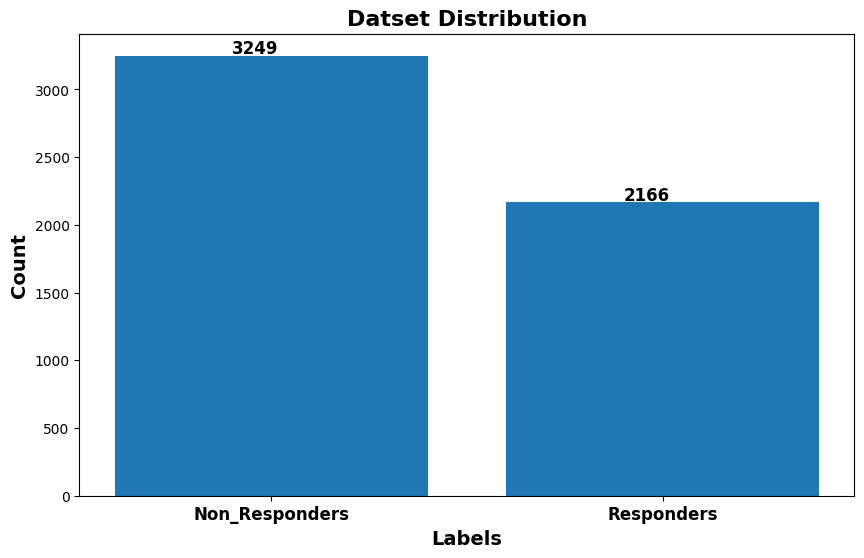

In [10]:
label_counts = df["label"].value_counts()

# Plotting the bar plot with count representation
fig, ax = plt.subplots(figsize=(10, 6)) 
bars = plt.bar(label_counts.index, label_counts.values, linewidth=1.5)

# Customize x-label and y-label size
plt.xlabel('Labels', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')

# Customize x-tick labels size and make them bold
plt.xticks(fontsize=12, fontweight='bold')

# Increase space between bars and count numbers
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 15, str(count), fontsize=12, fontweight='bold')

# Add a border to the bars
for bar in bars:
    bar.set_linewidth(1.5)

# Title of the plot
plt.title('Datset Distribution', fontsize=16, fontweight='bold')

# Show the plot
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

# Calculate the number of images for each class in the test set
test_size_percent = 0.1
num_responders_test = round(2166 * test_size_percent)  # Round to the nearest integer
num_non_responders_test = round(3249 * test_size_percent)  # Round to the nearest integer

# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=test_size_percent, stratify=df['label'], random_state=42)

# Displaying the shapes of the resulting DataFrames
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# Print the number of images in each class for the test set
print("Number of Responders in Test Set:", num_responders_test)
print("Number of Non_Responders in Test Set:", num_non_responders_test)


Train set shape: (4873, 2)
Test set shape: (542, 2)
Number of Responders in Test Set: 217
Number of Non_Responders in Test Set: 325


In [12]:
from sklearn.model_selection import StratifiedKFold

# Set up StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and validation sets
fold_train_dfs = []
fold_val_dfs = []

# Split the training set into 5 folds
for train_index, val_index in skf.split(train_df['path'], train_df['label']):
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]
    
    # Append to the lists
    fold_train_dfs.append(train_fold)
    fold_val_dfs.append(val_fold)

# Print the number of images in each class for each fold
for fold, (train_fold, val_fold) in enumerate(zip(fold_train_dfs, fold_val_dfs), 1):
    print(f"Fold {fold} - Training Set Class Distribution:")
    print(train_fold['label'].value_counts())
    print(f"\nFold {fold} - Validation Set Class Distribution:")
    print(val_fold['label'].value_counts())
    print("\n" + "-"*40)


Fold 1 - Training Set Class Distribution:
label
Non_Responders    2339
Responders        1559
Name: count, dtype: int64

Fold 1 - Validation Set Class Distribution:
label
Non_Responders    585
Responders        390
Name: count, dtype: int64

----------------------------------------
Fold 2 - Training Set Class Distribution:
label
Non_Responders    2339
Responders        1559
Name: count, dtype: int64

Fold 2 - Validation Set Class Distribution:
label
Non_Responders    585
Responders        390
Name: count, dtype: int64

----------------------------------------
Fold 3 - Training Set Class Distribution:
label
Non_Responders    2339
Responders        1559
Name: count, dtype: int64

Fold 3 - Validation Set Class Distribution:
label
Non_Responders    585
Responders        390
Name: count, dtype: int64

----------------------------------------
Fold 4 - Training Set Class Distribution:
label
Non_Responders    2340
Responders        1559
Name: count, dtype: int64

Fold 4 - Validation Set Class 

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
from keras.applications import ResNet152V2
# Define the input shape
input_shape = (224, 224, 3)

# Load the pre-trained ResNet152V2 model
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=input_shape)
# Add a global average pooling layer, BatchNormalization, and a dense output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Add BatchNormalization
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model 

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    

In [19]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 58,341,889 (222.56 MB)

 Trainable params: 58,194,049 (221.99 MB)

 Non-trainable params: 147,840 (577.50 KB)

In [20]:
# Initialize EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Fold 1
Start Time: 2024-05-10 03:07:36
Found 3898 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 975 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715310636.882553     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/122 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.7179 - loss: 0.5701 - val_accuracy: 0.7272 - val_loss: 0.5765
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 682ms/step - accuracy: 0.9224 - loss: 0.2073 - val_accuracy: 0.8544 - val_loss: 0.3455
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 680ms/step - accuracy: 0.9568 - loss: 0.1243 - val_accuracy: 0.9108 - val_loss: 0.2983
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 681ms/step - accuracy: 0.9739 - loss: 0.0753 - val_accuracy: 0.9538 - val_loss: 0.1241
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 83s 678ms/step - accuracy: 0.9900 - loss: 0.0325 - val_accuracy: 0.9538 - val_loss: 0.1498
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 680ms/step - accuracy: 0.9751 - loss: 0.0609 - val_accuracy: 0.9836 - val_loss: 0.0464
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 679ms/step - accuracy: 0.9944 - loss: 0.0212 - val_accuracy: 0.9456 - val_loss: 0.1678
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 678ms/step - accuracy: 0.9920 - loss: 0.0195 - val_a

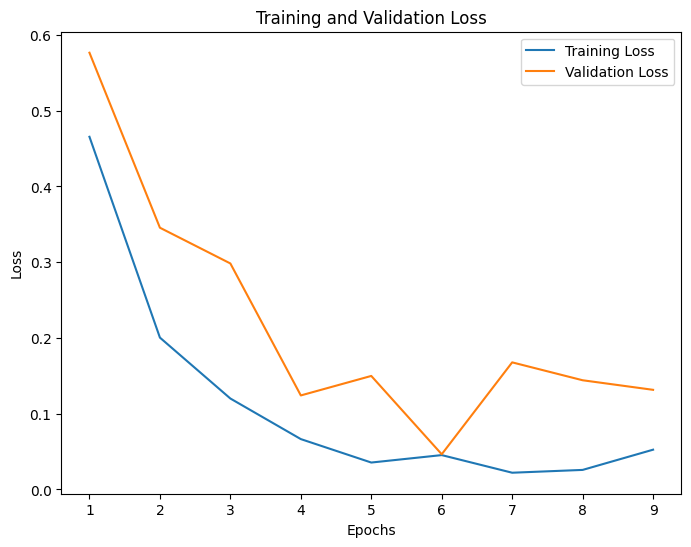

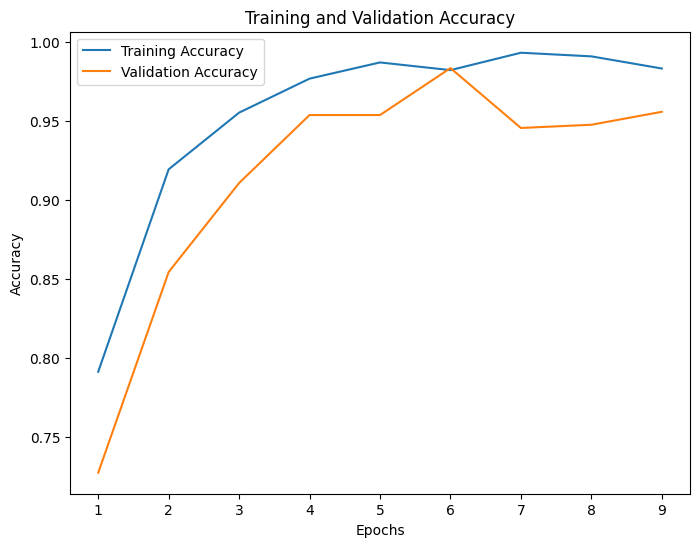

Fold 2
Start Time: 2024-05-10 03:24:50
Found 3898 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 975 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 683ms/step - accuracy: 0.9811 - loss: 0.0580 - val_accuracy: 0.9744 - val_loss: 0.0699
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 679ms/step - accuracy: 0.9781 - loss: 0.0597 - val_accuracy: 0.9795 - val_loss: 0.0602
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 681ms/step - accuracy: 0.9856 - loss: 0.0443 - val_accuracy: 0.9908 - val_loss: 0.0341
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 679ms/step - accuracy: 0.9905 - loss: 0.0334 - val_accuracy: 0.9703 - val_loss: 0.0841
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 681ms/step - accuracy: 0.9895 - loss: 0.0404 - val_accuracy: 0.9938 - val_loss: 0.0160
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 679ms/step - accuracy: 0.9962 - loss: 0.0089 - val_accuracy: 0.9928 - val_loss: 0.0171
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 679ms/step - accuracy: 0.9956 - loss: 0.0130 - val_accuracy: 0.9897 - val_loss: 0.0251
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 678ms/step - accuracy: 0.9979 - loss: 0.0049 - val

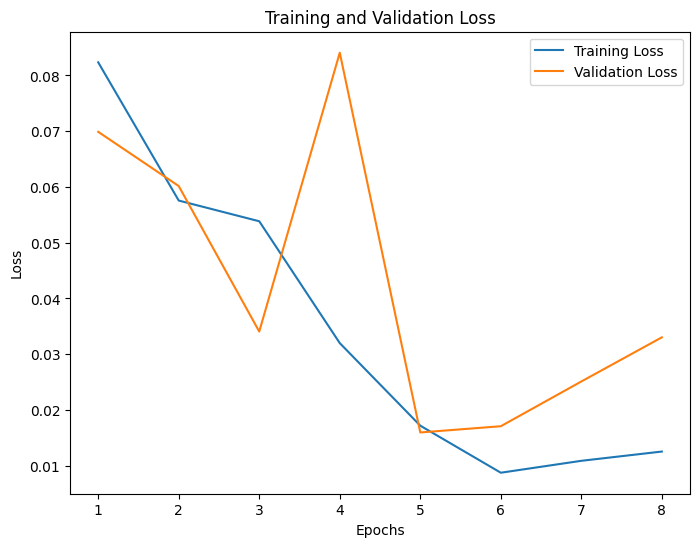

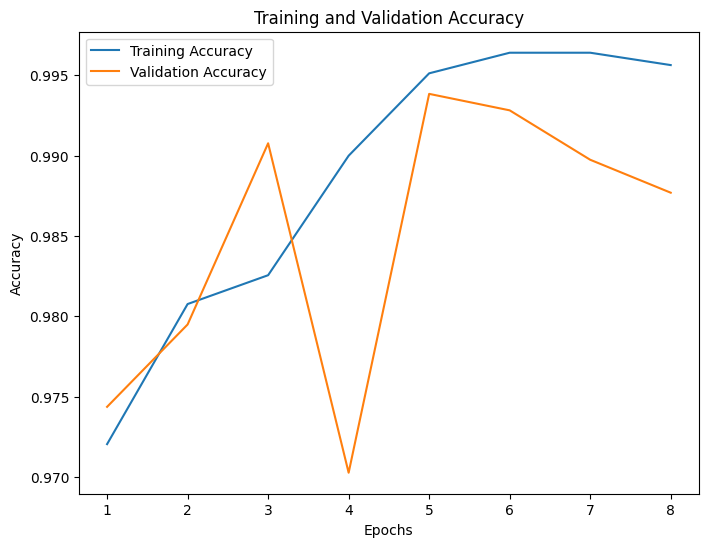

Fold 3
Start Time: 2024-05-10 03:36:02
Found 3898 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 975 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 683ms/step - accuracy: 0.9709 - loss: 0.1121 - val_accuracy: 0.9918 - val_loss: 0.0232
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 678ms/step - accuracy: 0.9922 - loss: 0.0207 - val_accuracy: 0.9959 - val_loss: 0.0189
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 681ms/step - accuracy: 0.9982 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 678ms/step - accuracy: 0.9998 - loss: 0.0025 - val_accuracy: 0.9918 - val_loss: 0.0203
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 679ms/step - accuracy: 0.9980 - loss: 0.0086 - val_accuracy: 0.9959 - val_loss: 0.0085
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 679ms/step - accuracy: 0.9919 - loss: 0.0231 - val_accuracy: 0.9323 - val_loss: 0.1716
End Time: 2024-05-10 03:44:27
Elapsed Time for Fold 3: 504.54 seconds

Training Loss: [0.08217106759548187, 0.028150305151939392, 0.007100983522832394, 0.005469186697155237, 0.009137372486293316, 0.022478049620985985]
Validat

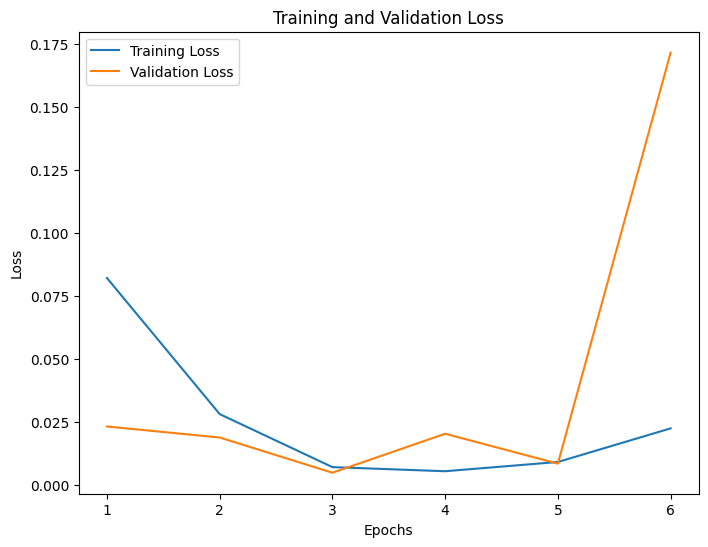

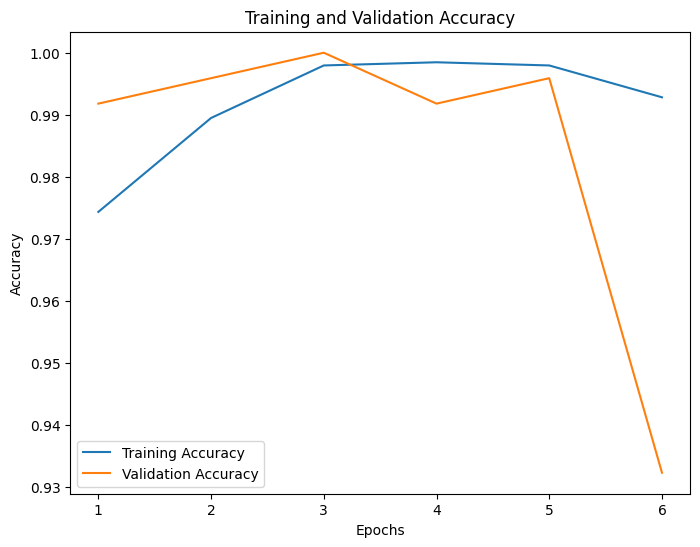

Fold 4
Start Time: 2024-05-10 03:44:27
Found 3899 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 974 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9978 - loss: 0.0069 - val_accuracy: 0.9949 - val_loss: 0.0158
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 678ms/step - accuracy: 0.9896 - loss: 0.0262 - val_accuracy: 0.9887 - val_loss: 0.0334
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 678ms/step - accuracy: 0.9932 - loss: 0.0216 - val_accuracy: 0.9928 - val_loss: 0.0236
End Time: 2024-05-10 03:50:10
Elapsed Time for Fold 4: 342.75 seconds

Training Loss: [0.01347154751420021, 0.033361904323101044, 0.030518807470798492]
Validation Loss: [0.015778644010424614, 0.03344602510333061, 0.023596035316586494]
Training Accuracy: [0.9946140050888062, 0.9876891374588013, 0.9897409677505493]
Validation Accuracy: [0.9948665499687195, 0.9887063503265381, 0.9928131699562073]


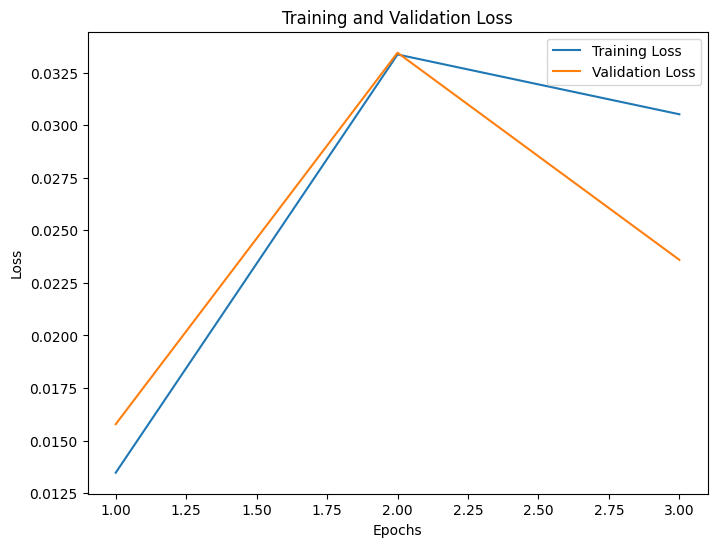

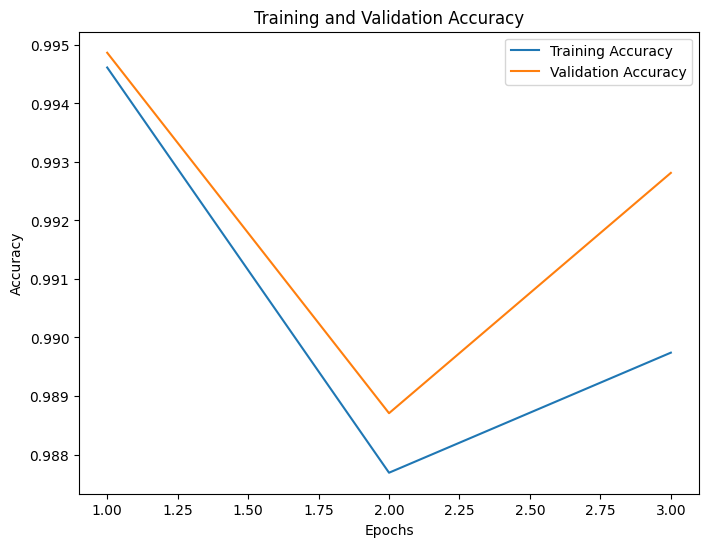

Fold 5
Start Time: 2024-05-10 03:50:11
Found 3899 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 974 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 683ms/step - accuracy: 0.9866 - loss: 0.0440 - val_accuracy: 0.9723 - val_loss: 0.0780
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 679ms/step - accuracy: 0.9936 - loss: 0.0173 - val_accuracy: 0.9661 - val_loss: 0.0791
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 679ms/step - accuracy: 0.9936 - loss: 0.0173 - val_accuracy: 0.9661 - val_loss: 0.0791
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 678ms/step - accuracy: 0.9939 - loss: 0.0172 - val_accuracy: 0.9867 - val_loss: 0.0368
End Time: 2024-05-10 03:54:24
Elapsed Time for Fold 5: 252.97 seconds

Training Loss: [0.043710801750421524, 0.020120792090892792, 0.011988593265414238]
Validation Loss: [0.07797888666391373, 0.07906926423311234, 0.03677041456103325]
Training Accuracy: [0.9864067435264587, 0.9938445687294006, 0.9964093565940857]
Validation Accuracy: [0.9722792506217957, 0.966119110584259, 0.9866529703140259]


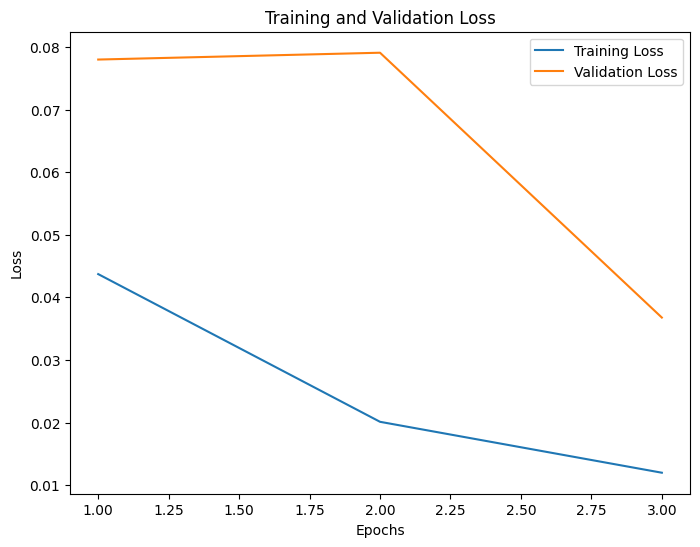

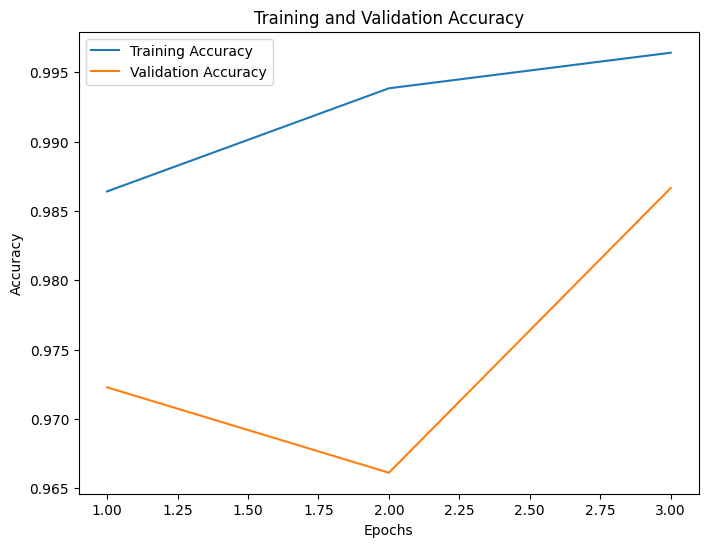

Total Training Time: 2805.73 seconds


In [21]:
# Number of epochs and batch size
epochs = 10
batch_size = 32

# Initialize lists to store loss and accuracy values
all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Initialize lists to store start and end times
all_start_times = []
all_end_times = []

# Loop through the folds and fit the model
for i in range(5):
    print("Fold", i + 1)

    # Record the start time for the current fold
    start_time = time.time()
    all_start_times.append(start_time)
    print("Start Time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time)))

    # Get the current fold's training and validation sets
    fold_train = fold_train_dfs[i]
    fold_val = fold_val_dfs[i]

    # Training generator
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=fold_train,
        x_col='path',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode='binary'
    )
    print("train_generator classes", train_generator.class_indices)

    # Validation generator
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=fold_val,
        x_col='path',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode='binary'
    )
    print("val_generator classes", val_generator.class_indices)

    # Fit the model on the current fold's training and validation data
    history = model.fit(
        train_generator,
        epochs=epochs,
        verbose=1,
        validation_data=val_generator,
        callbacks=[early_stop]
    )

    # Record the end time for the current fold
    end_time = time.time()
    all_end_times.append(end_time)
    print("End Time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time)))

    # Calculate and print the elapsed time for the current fold
    elapsed_time = end_time - start_time
    print("Elapsed Time for Fold {}: {:.2f} seconds\n".format(i + 1, elapsed_time))

    # Print the training and validation loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    print("Training Loss:", train_loss)
    print("Validation Loss:", val_loss)
    print("Training Accuracy:", train_acc)
    print("Validation Accuracy:", val_acc)

    # Append the loss and accuracy values to the lists
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

    # Plot the training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(history.epoch) + 1), train_loss, label='Training Loss')
    plt.plot(range(1, len(history.epoch) + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(history.epoch) + 1), train_acc, label='Training Accuracy')
    plt.plot(range(1, len(history.epoch) + 1), val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Calculate and print the total training time
total_training_time = sum(all_end_times) - sum(all_start_times)
print("Total Training Time: {:.2f} seconds".format(total_training_time))

In [25]:
# Calculate and print the average loss and accuracy
avg_train_loss = [sum(epoch_loss) / len(epoch_loss) for epoch_loss in all_train_loss]
avg_val_loss = [sum(epoch_loss) / len(epoch_loss) for epoch_loss in all_val_loss]
avg_train_acc = [sum(epoch_acc) / len(epoch_acc) for epoch_acc in all_train_acc]
avg_val_acc = [sum(epoch_acc) / len(epoch_acc) for epoch_acc in all_val_acc]

print("Average Training Loss:", avg_train_loss)
print("Average Validation Loss:", avg_val_loss)
print("Average Training Accuracy:", avg_train_acc)
print("Average Validation Accuracy:", avg_val_acc)

Average Training Loss: [0.11484647976855437, 0.0343811996281147, 0.025751160845781367, 0.02578408643603325, 0.02527339570224285]
Average Validation Loss: [0.22045885398983955, 0.042418160708621144, 0.04123097417565683, 0.02427356814344724, 0.06460618848601977]
Average Training Accuracy: [0.9533378945456611, 0.9886159598827362, 0.9918334285418192, 0.9906813700993856, 0.9922202229499817]
Average Validation Accuracy: [0.9147578411632113, 0.9848717898130417, 0.9846153855323792, 0.9921286900838217, 0.9750171105066935]


In [26]:
# Calculate and print the average loss and accuracy
mean_train_loss = sum(avg_train_loss) / len(avg_train_loss)
mean_val_loss = sum(avg_val_loss) / len(avg_val_loss)
mean_train_acc = sum(avg_train_acc) / len(avg_train_acc)
mean_val_acc = sum(avg_val_acc) / len(avg_val_acc)

print("Mean Training Loss:", mean_train_loss)
print("Mean Validation Loss:", mean_val_loss)
print("Mean Training Accuracy:", mean_train_acc)
print("Mean Validation Accuracy:", mean_val_acc)


Mean Training Loss: 0.04520726447614531
Mean Validation Loss: 0.07859754910071691
Mean Training Accuracy: 0.9833377752039167
Mean Validation Accuracy: 0.9702781634198295


In [27]:
# Record start time
start_time = time.time()

# Setting the test set as the final evaluation set
evaluation_set = test_df

# Print the length of the evaluation set
print("Evaluation set length:", len(evaluation_set))

# Evaluate the model on the evaluation set
evaluation_generator = test_datagen.flow_from_dataframe(
    dataframe=evaluation_set,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    seed=1234,
    shuffle=False,
    class_mode='binary'
)
print("evaluation_generator classes", evaluation_generator.class_indices)

evaluation_loss, evaluation_accuracy = model.evaluate(evaluation_generator)

# Record end time
end_time = time.time()

# Calculate and print the time taken for evaluation
elapsed_time = end_time - start_time
print("Time taken for evaluation:", elapsed_time, "seconds")

print("Evaluation Loss:", evaluation_loss)
print("Evaluation Accuracy:", evaluation_accuracy)

Evaluation set length: 542
Found 542 validated image filenames belonging to 2 classes.
evaluation_generator classes {'Non_Responders': 0, 'Responders': 1}


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.9521 - loss: 0.1712
Time taken for evaluation: 3.6132638454437256 seconds
Evaluation Loss: 0.17455151677131653
Evaluation Accuracy: 0.9575645923614502


In [28]:
# After training, save the model
model.save('MDD_ResNet152V2.h5')
print("Model saved successfully")

Model saved successfully


### Performanc Evaluation

In [31]:
# Predict on the evaluation set
evaluation_predictions = model.predict(evaluation_generator)
evaluation_pred_classes = (evaluation_predictions > 0.5).astype(int)  

# Get true labels
true_labels = evaluation_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, evaluation_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)



# Calculate classification report
class_report = classification_report(true_labels, evaluation_pred_classes)
print("Classification Report:")
print(class_report)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step
Confusion Matrix:
[[304  21]
 [  2 215]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       325
           1       0.91      0.99      0.95       217

    accuracy                           0.96       542
   macro avg       0.95      0.96      0.96       542
weighted avg       0.96      0.96      0.96       542



In [32]:
# Calculate classification report
class_report = classification_report(true_labels, evaluation_pred_classes)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       325
           1       0.91      0.99      0.95       217

    accuracy                           0.96       542
   macro avg       0.95      0.96      0.96       542
weighted avg       0.96      0.96      0.96       542



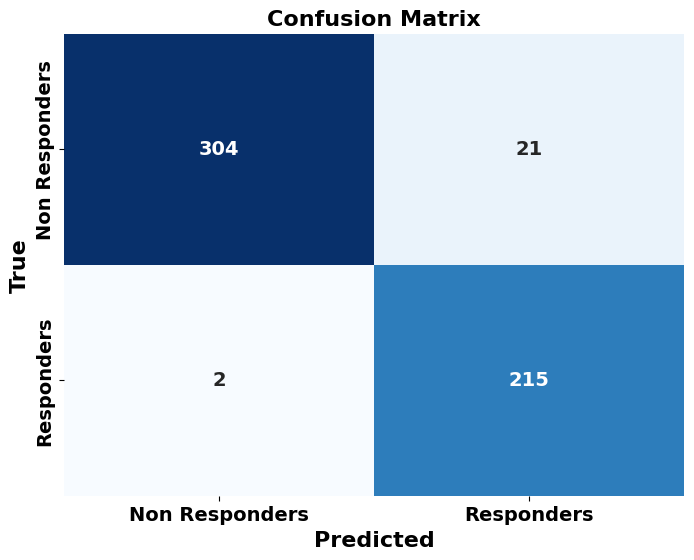

In [35]:
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Increase font size for true and predicted labels
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax, annot_kws={"size": 14, "weight": "bold"})  # Increase font size and weight for values
    
    # Increase font size and make class labels bold
    ax.set_xticklabels(class_names, fontsize=14, weight='bold')
    ax.set_yticklabels(class_names, fontsize=14, weight='bold')
    
    plt.xlabel('Predicted', fontsize=16, weight='bold')  
    plt.ylabel('True', fontsize=16, weight='bold')  # Increase font size and weight for y label
    plt.title('Confusion Matrix', fontsize=16, weight='bold')  # Increase font size and weight for title
    plt.show()

#  confusion matrix (conf_matrix) and class names
class_names = ['Non Responders', 'Responders']
plot_confusion_matrix(conf_matrix, class_names)


In [38]:
print(evaluation_generator.classes)

[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

In [39]:
# Get true labels
true_labels = evaluation_generator.classes

# Predict on the evaluation set
evaluation_predictions = model.predict(evaluation_generator)
predicted_labels = (evaluation_predictions > 0.5).astype(int)

# Initialize counters for correct and incorrect predictions
correct_predictions = 0
incorrect_predictions = 0

# Iterate over all predictions
for i in range(len(true_labels)):
    if true_labels[i] == predicted_labels[i]:
        correct_predictions += 1
    else:
        incorrect_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / (correct_predictions + incorrect_predictions)

# Print the results
print("Correct Predictions:", correct_predictions)
print("Incorrect Predictions:", incorrect_predictions)
print("Accuracy:", accuracy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step
Correct Predictions: 519
Incorrect Predictions: 23
Accuracy: 0.9575645756457565


In [40]:
# confusion matrix (conf_matrix) and class names
class_names = ['Non_Responders', 'Responders']

# Print confusion matrix with counts
for i in range(len(class_names)):
    print(f"\nClass: {i} ({class_names[i]})")
    true_positives = conf_matrix[i, i]
    true_negatives = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    print(f"True Positives (TP): {true_positives}")
    print(f"True Negatives (TN): {true_negatives}")
    print(f"False Positives (FP): {false_positives}")
    print(f"False Negatives (FN): {false_negatives}")
    print("====================")

# calculate and print overall metrics
overall_accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

print("\nOverall Metrics:")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Class: 0 (Non_Responders)
True Positives (TP): 304
True Negatives (TN): 215
False Positives (FP): 2
False Negatives (FN): 21

Class: 1 (Responders)
True Positives (TP): 215
True Negatives (TN): 304
False Positives (FP): 21
False Negatives (FN): 2

Overall Metrics:
Overall Accuracy: 0.9575645756457565
Precision: [0.99346405 0.91101695]
Recall: [0.93538462 0.99078341]


In [41]:
# confusion matrix (conf_matrix) and class names
class_names = ['Non_Responders', 'Responders']

# Print class-specific metrics
for i in range(len(class_names)):
    precision = conf_matrix[i, i] / np.sum(conf_matrix[:, i]) if np.sum(conf_matrix[:, i]) != 0 else 0
    recall = conf_matrix[i, i] / np.sum(conf_matrix[i, :]) if np.sum(conf_matrix[i, :]) != 0 else 0
    specificity = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1)) / (np.sum(conf_matrix) - np.sum(conf_matrix[:, i]) - np.sum(conf_matrix[i, :]) + conf_matrix[i, i])
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    print(f"\nClass: {class_names[i]}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-score: {f1_score:.4f}")
    print("====================")



Class: Non_Responders
Precision: 0.9935
Recall: 0.9354
Specificity: 1.0000
F1-score: 0.9635

Class: Responders
Precision: 0.9110
Recall: 0.9908
Specificity: 1.0000
F1-score: 0.9492


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step


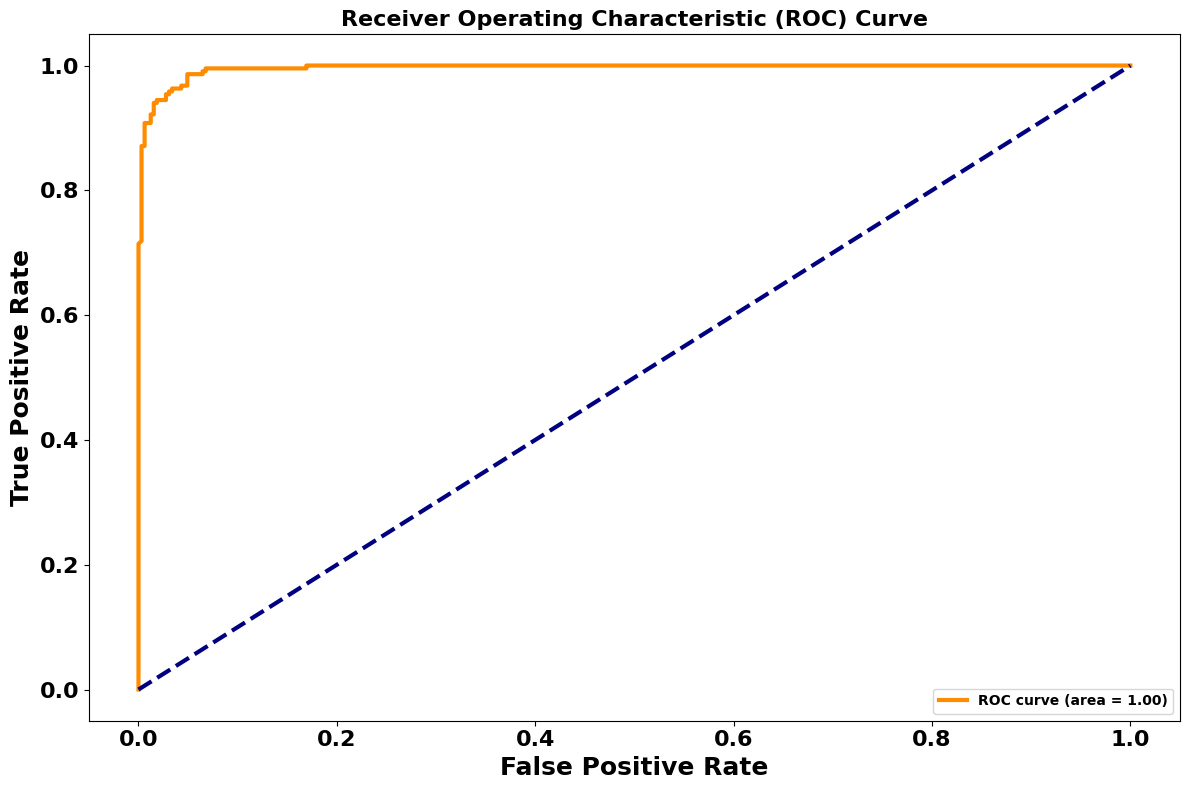

In [52]:
# true labels and predicted probabilities
true_labels = evaluation_generator.classes
predicted_probabilities = model.predict(evaluation_generator)



# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)
# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlabel('False Positive Rate', fontsize=18, weight='bold')  # Adjust x label properties
plt.ylabel('True Positive Rate', fontsize=18, weight='bold')  # Adjust y label properties
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, weight='bold')  # Adjust title properties
plt.legend(loc='lower right', fontsize=16, title_fontsize=16, fancybox=True, framealpha=0.7, edgecolor='black')  # Adjust legend properties
plt.xticks(fontsize=16, fontweight='bold')  # Increase font size of x ticks
plt.yticks(fontsize=16, fontweight='bold')  # Increase font size of y ticks

# Make text inside legend bold
legend = plt.legend(loc='lower right')
for text in legend.get_texts():
    text.set_weight('bold')

plt.tight_layout()

# # Save plot to local system
# plt.savefig('MDD_Xception_ROC.png')

plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step


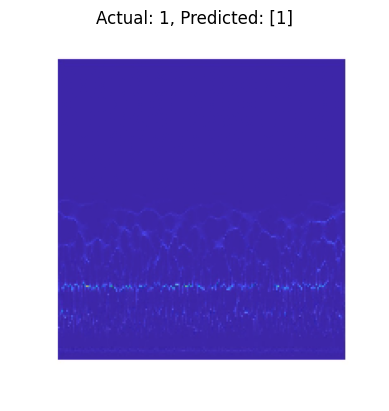

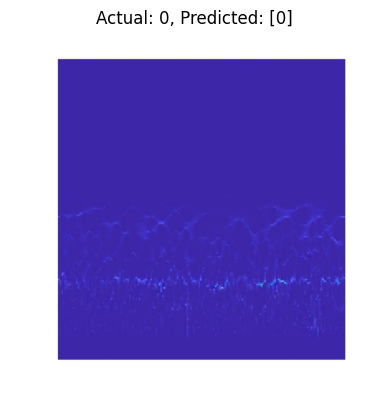

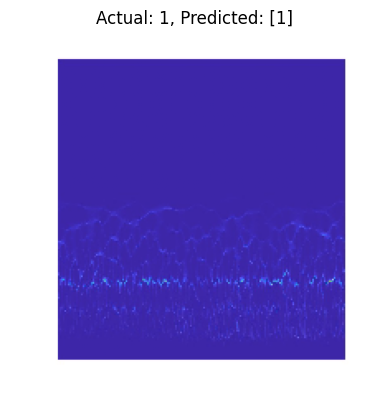

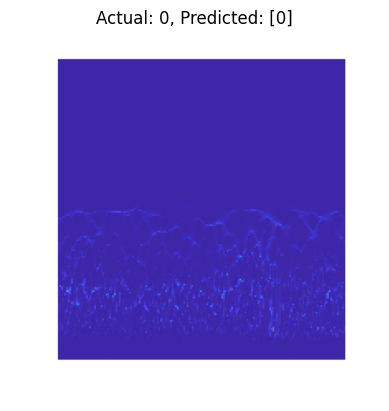

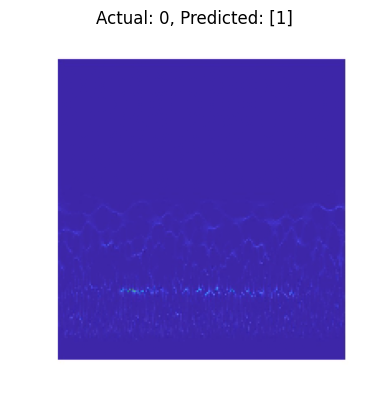

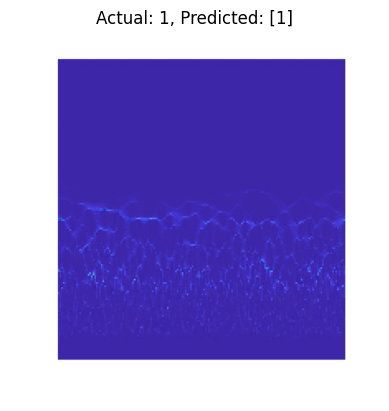

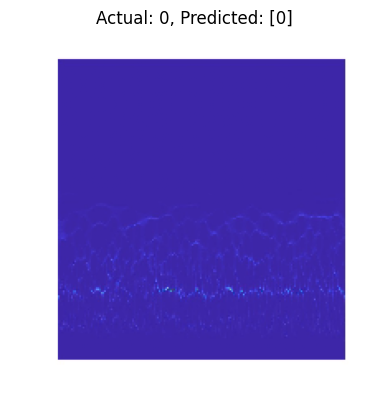

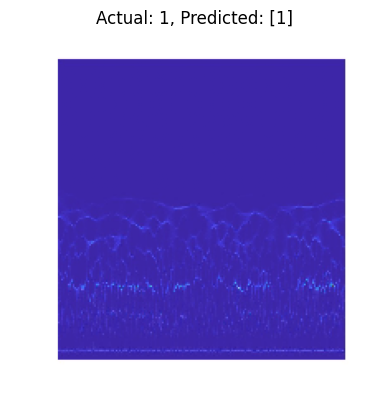

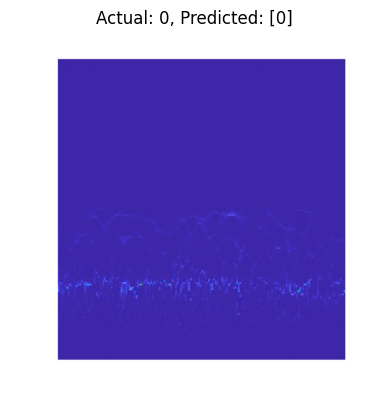

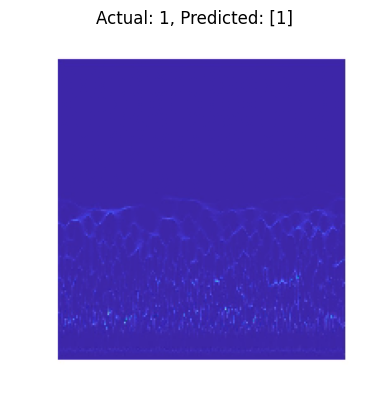

In [55]:
# Placeholder function for loading and preprocessing images
def load_and_preprocess_image(image_path):
    img = keras_image.load_img(image_path, target_size=(224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values to be between 0 and 1
    return img_array


# Get true labels
true_labels = evaluation_generator.classes

# Predict on the evaluation set
evaluation_predictions = model.predict(evaluation_generator)
predicted_labels = (evaluation_predictions > 0.5).astype(int)

# Display images along with actual and predicted labels
for i in range(len(true_labels[:10])):
    image_path = evaluation_set['path'].iloc[i]
    actual_label = true_labels[i]
    predicted_label = predicted_labels[i]

    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)

    # Display the image
    plt.imshow(image[0])  # Since image is a batch, select the first element
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()


In [56]:
from tensorflow.keras.models import load_model

# Load the saved CNN model
loaded_model = load_model('/kaggle/working/MDD_ResNet152V2.h5')

# evaluation set
evaluation_set = test_df

# Evaluate the loaded model on the evaluation set
evaluation_generator = test_datagen.flow_from_dataframe(
    dataframe=evaluation_set,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    seed=1234,
    shuffle=False,
    class_mode='binary'
)

# Evaluate the model
evaluation_loss, evaluation_accuracy = loaded_model.evaluate(evaluation_generator)

print("Evaluation Loss:", evaluation_loss)
print("Evaluation Accuracy:", evaluation_accuracy)

Found 542 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 428ms/step - accuracy: 0.9521 - loss: 0.1712
Evaluation Loss: 0.17455151677131653
Evaluation Accuracy: 0.9575645923614502
